# MNIST classification example with TensorFlow

## Install packages on Google  Cloud Datalab (locally use conda env)
### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==1.12**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Needed librairies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import gzip
import sys
import _pickle as cPickle

In [2]:
tf.__version__

'1.12.0'

## Import the Data

In [3]:
# get mnist data, split between train and test sets
# on GCP
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# with AXA network
def load_data(path):
    f = gzip.open(path, 'rb')
    if sys.version_info < (3,):
        data = cPickle.load(f)
    else:
        data = cPickle.load(f, encoding='bytes')
    f.close()
    return data
(x_train, y_train), (x_test, y_test) = load_data(path='../data/mnist.pkl.gz')

In [4]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [5]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [6]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [7]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

## Normalize and reorganize the data

In [8]:
# cast uint8 -> float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [9]:
# renormalize the data 255 grey variation
x_train /= 255
x_test /= 255

In [10]:
# reshape the data 28 x 28 -> 784
x_train = x_train.reshape(len(x_train), x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(len(x_test), x_test.shape[1]*x_test.shape[2])

In [11]:
x_train.shape

(60000, 784)

In [12]:
x_test.shape

(10000, 784)

## Reshape the labels

In [13]:
y_train.shape

(60000,)

In [14]:
y_test.shape

(10000,)

In [15]:
np.unique(y_train), np.unique(y_test)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [16]:
num_classes = len(np.unique(y_train))
num_classes

10

In [17]:
# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [18]:
y_train.shape

(60000, 10)

In [19]:
y_test.shape

(10000, 10)

In [20]:
dim_input=x_train.shape[1]
dim_input

784

## Visualize the data

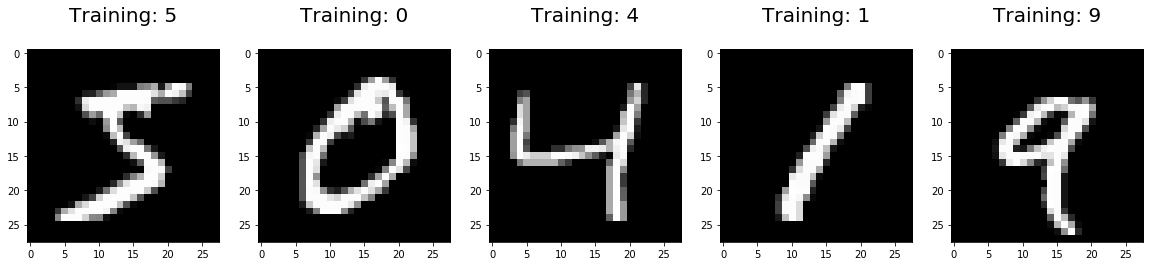

In [21]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % np.argmax(label), fontsize = 20)

## Defined some hyperparameters

In [22]:
# learning rate
learning_rate = 0.5

# number of epoch to train our model
EPOCHS = 1

# size of our mini batch
#BATCH_SIZE = len(x_train)
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = 1 #tf.contrib.data.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

# hidden layer 1
n1=300

In [23]:
BATCH_SIZE, EPOCHS

(128, 1)

## Defined flags

In [24]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)
    
del_all_flags(tf.flags.FLAGS)

In [25]:
tf.app.flags.DEFINE_string('f', '', 'kernel') # just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
tf.app.flags.DEFINE_string('model_dir', '../results/Models/Mnist/ckpt/', 'Dir to save a model and checkpoints')
tf.app.flags.DEFINE_string('saved_dir', '../results/Models/Mnist/pb/', 'Dir to save a model for TF serving')
tf.app.flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
tf.app.flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
tf.app.flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
tf.app.flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')
FLAGS = tf.app.flags.FLAGS

In [26]:
print(FLAGS)


C:\Program Files\Anaconda3\envs\env_gcp_dl\lib\site-packages\ipykernel_launcher.py:
  --batch_size: Batch size
    (default: '128')
    (an integer)
  --f: kernel
    (default: '')
  --model_dir: Dir to save a model and checkpoints
    (default: '../results/Models/Mnist/ckpt/')
  --num_parallel_calls: Number of paralell calls
    (default: '4')
    (an integer)
  --prefetch_buffer_size: Prefetch buffer size
    (default: '1')
    (an integer)
  --saved_dir: Dir to save a model for TF serving
    (default: '../results/Models/Mnist/pb/')
  --shuffle_buffer_size: Shuffle buffer size
    (default: '1280')
    (an integer)

absl.flags:
  --flagfile: Insert flag definitions from the given file into the command line.
    (default: '')
  --undefok: comma-separated list of flag names that it is okay to specify on
    the command line even if the program does not define a flag with that name.
    IMPORTANT: flags in this list that have arguments MUST use the --flag=value
    format.
    (defaul

## Using tf.data.Dataset
https://www.tensorflow.org/guide/performance/datasets  
To summarize, one good order for the different transformations is:
- create the dataset
- shuffle (with a big enough buffer size)
- repeat
- map with the actual work (preprocessing, augmentation…) using multiple parallel calls
- batch
- prefetch

ModeKeys:  
https://www.tensorflow.org/api_docs/python/tf/estimator/ModeKeys  
- EVAL
- PREDICT
- TRAIN

In [27]:
def input_dataset_fn(x_data, y_data, batch_size=128, mode=tf.estimator.ModeKeys.TRAIN):
    
    # 1) convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    
    # 2) shuffle (with a big enough buffer size)    :        
    if mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None # loop indefinitely
        dataset = dataset.shuffle(buffer_size=FLAGS.shuffle_buffer_size, seed=2)# depends on sample size
    else:
        num_epochs = 1 # end-of-input after this
        
    # caching data
    #dataset = dataset.cache()
    
    # 3) automatically refill the data queue when empty
    dataset = dataset.repeat(num_epochs)
    
    # 4) map
    #dataset = dataset.map(map_func=parse_fn, num_parallel_calls=FLAGS.num_parallel_calls)

    # 5) create batches of data
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    
    # 6) prefetch data for faster consumption, based on your system and environment, allows the tf.data runtime to automatically tune the prefetch buffer sizes
    dataset = dataset.prefetch(FLAGS.prefetch_buffer_size)

    return dataset

In [28]:
training_dataset = input_dataset_fn(x_train, 
                                    y_train, 
                                    mode=tf.estimator.ModeKeys.TRAIN, 
                                    batch_size=FLAGS.batch_size)
testing_dataset = input_dataset_fn(x_test, 
                                   y_test,
                                   mode=tf.estimator.ModeKeys.EVAL, 
                                   batch_size=len(x_test))

### exploration dataset API

In [29]:
iterator = training_dataset.make_one_shot_iterator()

In [30]:
# next_element
features, labels = iterator.get_next()

In [31]:
len(x_train)/BATCH_SIZE

468.75

In [32]:
n=0
n_iter=470
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print('iteration n:', n, 'execution time:', time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
            n+=1
            if n>=n_iter:
                print('number of iteration reached')
                break
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

iteration n: 0 execution time: 31.20903664043739 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 1 execution time: 0.0008253915512526078 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 2 execution time: 0.0010455211369695405 seconds
(128, 784)
(128, 10)
first label of the batch 6 

iteration n: 3 execution time: 0.001849390584645505 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 4 execution time: 0.0017738744317412625 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 5 execution time: 0.0028477141260516703 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 6 execution time: 0.0016175559952280594 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 7 execution time: 0.000946594976667825 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 8 execution time: 0.0007691320173393024 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iterati

iteration n: 101 execution time: 0.0017308302245844231 seconds
(128, 784)
(128, 10)
first label of the batch 6 

iteration n: 102 execution time: 0.004130355983146927 seconds
(128, 784)
(128, 10)
first label of the batch 7 

iteration n: 103 execution time: 0.002874144779568155 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 104 execution time: 0.000771775082689885 seconds
(128, 784)
(128, 10)
first label of the batch 0 

iteration n: 105 execution time: 0.0006196100345832178 seconds
(128, 784)
(128, 10)
first label of the batch 6 

iteration n: 106 execution time: 0.0011731434353805525 seconds
(128, 784)
(128, 10)
first label of the batch 3 

iteration n: 107 execution time: 0.0007925420247403281 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 108 execution time: 0.00078725589403561 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 109 execution time: 0.0019226412529640413 seconds
(128, 784)
(128, 10)
first label of th

iteration n: 253 execution time: 0.001634924710394614 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 254 execution time: 0.006376583951304582 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 255 execution time: 0.0013279515488378024 seconds
(128, 784)
(128, 10)
first label of the batch 4 

iteration n: 256 execution time: 0.001112352932292282 seconds
(128, 784)
(128, 10)
first label of the batch 4 

iteration n: 257 execution time: 0.002730286508285218 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 258 execution time: 0.0010670432405461838 seconds
(128, 784)
(128, 10)
first label of the batch 0 

iteration n: 259 execution time: 0.00214428116174048 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 260 execution time: 0.0009987011221710418 seconds
(128, 784)
(128, 10)
first label of the batch 7 

iteration n: 261 execution time: 0.0011199045475827063 seconds
(128, 784)
(128, 10)
first label of the

iteration n: 338 execution time: 0.0014317862590829122 seconds
(128, 784)
(128, 10)
first label of the batch 3 

iteration n: 339 execution time: 0.0006067722885916282 seconds
(128, 784)
(128, 10)
first label of the batch 3 

iteration n: 340 execution time: 0.0007581821751685425 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 341 execution time: 0.0014706770778332157 seconds
(128, 784)
(128, 10)
first label of the batch 3 

iteration n: 342 execution time: 0.0017025116672471086 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 343 execution time: 0.001287550407027993 seconds
(128, 784)
(128, 10)
first label of the batch 4 

iteration n: 344 execution time: 0.001321910256606884 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 345 execution time: 0.0012475268459937183 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 346 execution time: 0.0035832414553453873 seconds
(128, 784)
(128, 10)
first label of

iteration n: 468 execution time: 0.007889550074764884 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 469 execution time: 0.003423902372716725 seconds
(128, 784)
(128, 10)
first label of the batch 4 

number of iteration reached


In [33]:
iterator = testing_dataset.make_one_shot_iterator()

In [34]:
# next_element
features, labels = iterator.get_next()

In [35]:
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print(time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

8.404994260772376 seconds
(10000, 784)
(10000, 10)
first label of the batch 7 

tf.errors.OutOfRangeError


### Keras Call back

In [36]:
class UDFPrint(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        _, __, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        print('Reached epoch {0:3d} cost J = {1:.5f}'.format(epoch, loss_train))
        return

    def on_epoch_end(self, epoch, logs={}):
        x_test, y_test, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        loss_test, acc_test = self.model.evaluate(x_test, y_test, verbose=0)
        print(' accurary on the training set {0:.4f}'.format(acc_train))
        print(' accurary on the testing set {0:.4f}'.format(acc_test))

    def on_batch_begin(self, batch, logs={}):
        #print('  ---> starting minibatch', batch)
        return

    def on_batch_end(self, batch, logs={}):
        #print('  ---> ending minibatch', batch)
        return
return

## Defined our model

In [37]:
def baseline_model():
    # create model
    model = tf.keras.Sequential()
 
    # hidden layer
    model.add(tf.keras.layers.Dense(dim_input, 
                    input_dim=dim_input, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='relu'))
    # last layer
    model.add(tf.keras.layers.Dense(num_classes, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='softmax'))
    
    # weight initialisation
    # He: keras.initializers.he_normal(seed=None)
    # Xavier: keras.initializers.glorot_uniform(seed=None)
    # Radom Normal: keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    # Truncated Normal: keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
    
    # optimiser
    optimiser=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9)
    # GD/SGC: keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    # Adam: keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    # RMSProp: keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    # Momentum: keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimiser, 
                  metrics=['accuracy'])
    return model

In [38]:
# build the model
model = baseline_model()

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


## Store the original weights

In [40]:
initial_weights = model.get_weights()

## Fit the model using numpy array  
- batch_size 
  determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- steps_per_epoch 
  the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- validation_steps 
  similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



In [41]:
# Set to the original weights for testing other pipelines
model.set_weights(initial_weights)

# Fit the model
hist=model.fit(x_train, 
               y_train, 
               validation_data=(x_test, y_test),
               callbacks=[UDFPrint((x_test, y_test, x_train, y_train))],
               epochs=EPOCHS, 
               batch_size=BATCH_SIZE,
               verbose=2)

Train on 60000 samples, validate on 10000 samples
Reached epoch   0 cost J = 2.36279
Epoch 1/1
 accurary on the training set 0.9643
 accurary on the testing set 0.9575
 - 30s - loss: 0.2129 - acc: 0.9364 - val_loss: 0.1364 - val_acc: 0.9575


In [42]:
print(hist.history)

{'val_loss': [0.13635853647589682], 'val_acc': [0.9575], 'loss': [0.21294182267189027], 'acc': [0.9364000000317891]}


In [43]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.13635853157509117
Test accuracy: 0.9575


In [44]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.11482920307964087
Train accuracy: 0.9643333333333334


In [45]:
len(x_train) //BATCH_SIZE

468

## Fit the model using data.dataset

In [46]:
# Set to the original weights for testing other pipelines
model.set_weights(initial_weights)

# Fit the model (using data.Dataset)
hist=model.fit(training_dataset.make_one_shot_iterator(),
               steps_per_epoch=len(x_train) // BATCH_SIZE,
               validation_data=testing_dataset.make_one_shot_iterator(),
               validation_steps=1, #len(x_test) // BATCH_SIZE,
               #callbacks=[UDFPrint((x_test, y_test, x_train, y_train))],
               epochs=EPOCHS,
               verbose = 2)

Epoch 1/1
 - 71s - loss: 0.2425 - acc: 0.9334 - val_loss: 0.1384 - val_acc: 0.9597


In [47]:
print(hist.history)

{'val_loss': [0.13841287791728973], 'val_acc': [0.9596999883651733], 'loss': [0.24246805959229922], 'acc': [0.9334435096153846]}


In [48]:
score = model.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.13841325899201912
Test accuracy: 0.9597


In [49]:
score = model.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.10989328846385081
Train accuracy: 0.9657


## Fit the model using data.dataset

In [ ]:
! rm -r ../results/Models/Mnist/ckpt

In [70]:
!rmdir /S /Q "../results/Models/Mnist/ckpt"

In [71]:
class TimeHistory(tf.train.SessionRunHook):
    def begin(self):
        self.times = []

    def before_run(self, run_context):
        self.iter_time_start = time.time()

    def after_run(self, run_context, run_values):
        self.times.append(time.time() - self.iter_time_start)

In [72]:
time_hist = TimeHistory()

In [80]:
# the tf.distribute.Strategy API is an easy way to distribute your training across multiple devices/machines
NUM_GPUS = 2
strategy=None
#strategy = tf.contrib.distribute.OneDeviceStrategy('device:CPU:0')
#strategy = tf.contrib.distribute.OneDeviceStrategy('device:GPU:0')
#strategy = tf.contrib.distribute.MirroredStrategy(num_gpus=NUM_GPUS)

# config tf.estimator to use a give strategy
training_config = tf.estimator.RunConfig(train_distribute=strategy,
                                         model_dir=FLAGS.model_dir,
                                         save_summary_steps=20,
                                         save_checkpoints_steps=20)

In [81]:
# Set to the original weights for testing other pipelines
#model.set_weights(initial_weights)

# transfor keras model to estimator model
estimator_train_model = tf.keras.estimator.model_to_estimator(keras_model=model,
                                                              config=training_config)

INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': '../results/Models/Mnist/ckpt/', '_tf_random_seed': None, '_save_summary_steps': 20, '_save_checkpoints_steps': 20, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001E27E31DD68>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [82]:
!ls ../results/Models/Mnist/ckpt

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [83]:
!dir /B "../results/Models/Mnist/ckpt"

keras


### Training our model

In [84]:
def get_train_input_fn():
    return input_dataset_fn(x_train,
                            y_train, 
                            mode=tf.estimator.ModeKeys.TRAIN, 
                            batch_size=FLAGS.batch_size)

In [85]:
# Fit the model (using estimator.train and data.Dataset)
#estimator_train_model.train(input_fn=lambda:input_dataset_fn(x_train, y_train, is_training=True, batch_size=BATCH_SIZE),
#                            max_steps=1,
#                            hooks=[time_hist])
estimator_train_model.train(input_fn=get_train_input_fn,
                            #max_steps=1,
                            steps=10,
                            hooks=[time_hist])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='../results/Models/Mnist/ckpt/keras\\keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('../results/Models/Mnist/ckpt/keras\\keras_model.ckpt',)
INFO:tensorflow:Warm-starting variable: dense/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_1/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: Adam/iterations; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: Adam/lr; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: Adam/beta_1; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: Adam/beta

### Evaluating the accuracy of our model

In [ ]:
score=estimator_train_model.evaluate(input_fn=lambda:input_dataset_fn(x_train,y_train, mode=tf.estimator.ModeKeys.TRAIN, batch_size=1000))

In [ ]:
print('Train loss:', score['loss'])
print('Train accuracy:', score['accuracy'])
print('Train global steps:', score['global_step'])

In [ ]:
score=estimator_train_model.evaluate(input_fn=lambda:input_dataset_fn(x_test, y_test,mode=tf.estimator.ModeKeys.EVAL, batch_size=len(x_test)))

In [ ]:
print('Test loss:', score['loss'])
print('Test accuracy:', score['accuracy'])
print('Test global steps:', score['global_step'])

In [ ]:
score

### Generating predictions on our trained model

In [84]:
examples=x_test[0:5]

In [87]:
predictions=list(estimator_train_model.predict(input_fn=lambda:input_dataset_fn(examples, is_training=False, batch_size=BATCH_SIZE)))

ValueError: None values not supported.

In [86]:
for i in range(len(examples)):
    prediction_array = predictions[i].values()[0]
    predicted_label = text_labels[np.argmax(prediction_array)]
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

TypeError: 'generator' object is not subscriptable